## High Level Overview

Once every few days, Starbucks sends out an offer to users. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free).

The purpose of the project is to create a classifier to predict whether a user will respond to an offer, or in other words, complete an offer.

Sending each offer has a cost for the company, so each offer that is not completed is a waste of money for the company. On the other hand, every completed offer is beneficial to the company ( could be loyality of the customer, keeping them active, etc.). So in an ideal world, the company would send offers to all the users who would complete them and only to those users. The classifier would help them move towards this goal.

## Strategy

The stesps to take are:
1. Exploratory Data Analysis (EDA) to get information about the data
2. Transform data for training and testing
3. Choose the best classifier
4. Train -> Test -> Evaluate -> Improve loop until we're satisfied with the results
5. Create a python application that can be run from terminal. The application will need person id and offer id to predict whether a person will respond to an offer. The results will be output as a csv file.

## Description of Input Data

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import json
import time
from datetime import date, datetime
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
# Shape of Portfolio
portfolio.shape

(10, 6)

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Check portfolio df shape
portfolio.shape

(10, 6)

In [8]:
# Small dataframe, so we can display all of it
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [9]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


**Findings**
* We have offer_type 'informational', for which we can not say for sure if a user responded to it, so we might as well
drop them;
* The company uses 4 channels of communication. The column contains dictionaries, so we'll probably need to unpack later;

In [10]:
# Check Transcript
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
# Check nulls
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [12]:
# Check event types
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**Findings**
* Column 'value' contains dictionaries, we'll probably need to unpack later
* No nulls in our transaction dataset, very nice
* 4 types of events, we'll probably mostly use offer related ones

In [13]:
# Check time column stats
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [14]:
# Check value column dictionary keys
transcript['value'].apply(lambda x: ', '.join(x.keys())).value_counts()

amount              138953
offer id            134002
offer_id, reward     33579
Name: value, dtype: int64

In [15]:
transcript['keys'] = transcript['value'].apply(lambda x: ', '.join(x.keys()))

transcript.groupby(['event', 'keys']).count()

,,person,time,value
event,keys,,,
offer completed,"offer_id, reward",33579,33579,33579
offer received,offer id,76277,76277,76277
offer viewed,offer id,57725,57725,57725
transaction,amount,138953,138953,138953


In [16]:
transcript.drop('keys', axis = 1, inplace = True)

**Findings**
* Column 'value' has different spelling for different events, 'offer_id' for 'offer completed' and 'offer id' for others

offer received     0.455165
offer viewed       0.344460
offer completed    0.200375
Name: event, dtype: float64

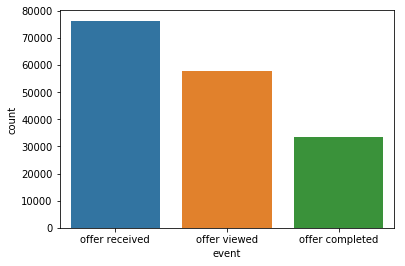

In [17]:
# Let's check the funnel offer received -> offer viewed -> offer completed
sns.countplot(transcript[transcript['event'] != 'transaction']['event'])

transcript[transcript['event'] != 'transaction']['event'].value_counts() / transcript[transcript['event'] != 'transaction']['event'].shape[0]


**Findings**
* The funnel ratios by stages are about 9-7-4, so about 78% of received offers get viewed and 44% get completed.
* In business terms, if our predictions help marketing team get more than 44% completed with the same budget spent, we've made progress

In [18]:
# Let's check max values of time for each event
transcript.groupby('event').max()['time']

event
offer completed    714
offer received     576
offer viewed       714
transaction        714
Name: time, dtype: int64

**Findings**
* Maximum 'time' for 'offer received' is 576, while for others it's 714. Which means we can make decisions for all of the offers received

In [19]:
# Chek profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [20]:
# Seems like we have nulls
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [21]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


**Findings**
* Looks like we have same number of nulls in 'gender' and 'income' columns
* Having three 118 year olds in the first 5 rows is a bit suspicious. 118 is the highest age so it's probably a default value

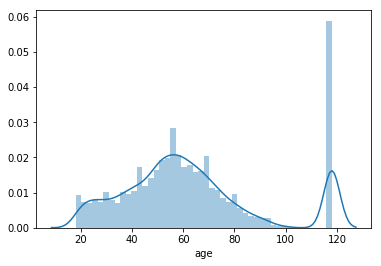

In [22]:
# Check age distribution
sns.distplot(profile['age'])

In [23]:
# Check number of age == 118
profile[profile['age'] == 118].shape[0]

2175

**Findings**
* Looks like we have same number of nulls in 'gender' and 'income' columns
* Maximum value of age is 118 and about 6% are of this age, it's most likely a default value for age when registering. They're basically nulls for age.
* We have the same number of gender/income nulls as 118 year olds, they're probably the same users

In [24]:
profile[profile['age'] == 118].isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [25]:
# Looks like they are the same rows

# Data Preparation

Data Preparation process has the following steps:
1. Clean Portfolio Dataset
2. Clean Profile Dataset
3. Process Transcript Dataset
4. Engineer Features
5. Merge Datasets
6. Split into Train and Test
7. Explore and Modify Train Set

First thing to do is clean and merge datasets.

### 1. Clean Portfolio Dataset

In [26]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [27]:
def clean_portfolio(df):
    '''
    DESCRIPTION
    Prepare porttfolio dataframe
    
    INPUT
    df - portfolio dataframe
    
    OUTPUT
    df_cleaned - cleaned portfolio dataaframe
    '''
    # Remove offer_type'informational' because users canno't respond to such type
    df_cleaned = df[df['offer_type'] != 'informational']
    
    # Rename id to offer_id to later merge to transactions df
    df_cleaned.rename(columns = {"id": 'offer_id'}, inplace = True)
    
    # Create dummy variables for channels
    df_cleaned['social'] = df_cleaned['channels'].apply(lambda x: 1 if 'social' in x else 0)
    df_cleaned['mobile'] = df_cleaned['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    
    # Create dummy variable for offer_type
    df_cleaned['bogo'] = df_cleaned['offer_type'].apply(lambda x: 1 if x == 'bogo' else 0)
    
    # Drop channels and offer_type columns
    df_cleaned.drop(['channels', 'offer_type'], axis = 1, inplace = True)
    
    # Return cleaned df
    return df_cleaned

In [28]:
portfolio_cleaned = clean_portfolio(portfolio)

In [29]:
portfolio_cleaned.head()

,difficulty,duration,offer_id,reward,social,mobile,bogo
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,0


### 2. Clean Profile Dataset

In [30]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [31]:
def clean_profile(df):
    '''
    DESCRIPTION
    Prepares profile dataframe
    
    INPUT
    df - profile data
    
    OUTPUT
    df_cleaned - data with no null values
    df_nulls - data with nulls or default values
    '''
    # Rename 'id' to 'person' for later join with transactions df
    df_new = df.rename(columns = {"id": 'person'})
    
    # Change registration date to days_registered
    df_new['days_registered'] = df_new['became_member_on'].apply(lambda x: (pd.to_datetime('today').normalize() -
                                                     datetime(int(str(x)[0:4]), int(str(x)[4:6]), int(str(x)[6:]))).days)
    
    # Drop beame_member_on
    df_new.drop('became_member_on', axis = 1, inplace = True)
    
    # Return
    return df_new

In [32]:
profile_cleaned = clean_profile(profile)

In [33]:
profile_cleaned.head()

,age,gender,person,income,days_registered
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2467
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2314
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1952
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2381
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2294


### 3. Process Transcript Dataset

We want to understand which offers were completed, in other words, responded to.

We call an offer responded if the user went through the whole funnel, meaning, he/she received an offer, viewed it and completed. If a user received an offer and completed without viewing, we don't say he/she converted.

Funnel:  offer received -> offer viewed -> offer completed

In [34]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
def process_transcript(df):
    '''
    DESCRIPTION
    From transcript dataframe, for each 'offer received' event, returns whether a user responded to an event
    Adds one column:
    responded - 1 if a user responded to an offer, 0 if didn't
    
    INPUT
    df - dataframe of transactions
    
    OUTPUT
    df_cleaned = cleaned dataframe of transaction
    '''
    # Drop transacation events
    df_cleaned = df[df['event'] != 'transaction']
    
    # Get offer_ids from 'value' column dictionaries
    df_cleaned['offer_id'] = df_cleaned['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'])
    
    # Drop 'Value' column
    df_cleaned = df_cleaned.drop(['value'], axis = 1)
    
    # Sort data for Window Functions
    df_cleaned = df_cleaned.sort_values(['person', 'offer_id', 'time'])
    
    # For each user & offer & time, get the next two actions as a separate column
    df_cleaned['step_1'] = df_cleaned['event'].shift(-1)
    df_cleaned['step_2'] = df_cleaned['event'].shift(-2)
    
    # Leave rows with 'offer receieved' as 'event' and remove 'event' field
    df_cleaned = df_cleaned[df_cleaned['event'] == 'offer received'].drop('event', axis = 1)
    
    # Add column 'responded', logic - if a user viewed and then completed, then 1, else 0
    df_cleaned['responded'] = (df_cleaned['step_1'] == 'offer viewed') & (df_cleaned['step_2'] == 'offer completed')
    df_cleaned['responded'] = df_cleaned['responded'].map({True: 1, False: 0})
    
    # Drop step columns
    df_cleaned = df_cleaned.drop(['step_1', 'step_2'], axis = 1)
    
    # return cleaned df
    return df_cleaned

In [36]:
processed_transcript = process_transcript(transcript)

In [37]:
processed_transcript.head()

,person,time,offer_id,responded
247879,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,0
113605,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,0
55972,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,0
153401,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,0
204340,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,0


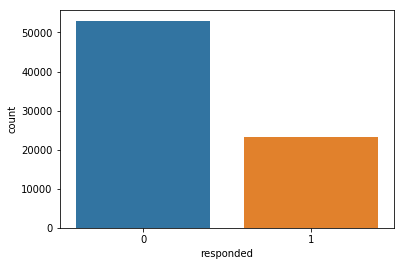

In [38]:
# Check counts of 'responded'
sns.countplot(processed_transcript['responded'])

In [39]:
# Check percentages
processed_transcript['responded'].value_counts()/processed_transcript.shape[0]

0    0.694967
1    0.305033
Name: responded, dtype: float64

**Findings**

About 70% of received offers are not responded to. So in numbers, what we want to achieve when using our classifier is raise the percentage of 1-s, in other words, conversion rate.

## 4. Engineer Features

We add three features to processed_transcript dataframe:
* avg_spent - average amount spent by a customer
* trans_cnt - average transactions made by a customer (in transcript dataset, event = transaction)
* prev_resp - 1 if user has previously responded an offer with the same offer_id, 0 if hasn't

The process:
1. Get a dataframe of avg_spent per user and trans_cnt per user ( functions: get_avg_spent, get_trans_cnt)
2. Merge with processed_transcript (functions: engineer_event_aggs)
3. Calculate prev_resp from processed_transcript (function: engineer_prev_resp_for_fit)

In [40]:
def get_avg_spent(df):
    '''
    DESCRIPTION
    Takes transcript dataframe and returns average amount spent by each user
    
    INPUT
    df - transcript dataframe
    
    OUTPUT
    avg_spent - average amount spent dataframe with two columns - person, avg_spent
    
    '''
    # Get transactions
    df = df[df['event'] == 'transaction']
    
    # Get amounts from value column dictionaries
    df['avg_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    # Get average amount spent per user
    avg_spent = df.groupby('person').mean()['avg_spent'].to_frame()
    
    # Return average amount per user
    return avg_spent

In [41]:
def get_trans_cnt(df):
    '''
    DESCRIPTION
    Takes transcript dataframe and returns transaction count per user
    
    INPUT
    df - transcript dataframe
    
    OUTPUT
    trans_cnt - transaction count dataframe with two columns - person, trans_cnt
    
    '''
    # Get transaction count per user
    trans_cnt = df[df['event'] == 'transaction'].groupby('person').count()['event'].to_frame().rename({'event':'trans_cnt'}, axis = 1)
    
    # Return transaction count per user
    return trans_cnt

In [42]:
def engineer_event_aggs(df, transcript):
    '''
    DESCRIPTION
    Adds transaction count and average amount spent columns 
    
    INPUT
    df - transcript dataframe
    
    OUTPUT
    df_new - transcipt dataframe with added columns
    
    '''
    # Get transaction count per user
    cnt_dict = get_trans_cnt(transcript)
    df_new = df.merge(cnt_dict, how = 'left', on = 'person')
    
    # Get average spent per user
    avg_spent_dict = get_avg_spent(transcript)
    df_new = df_new.merge(avg_spent_dict, how = 'left', on = 'person')
    
    # Fillna with 0-s
    df_new.fillna(0, inplace = True)
    
    # Return
    return df_new


In [43]:
# Add avg_spent and trans_cnt
processed_transcript = engineer_event_aggs(processed_transcript, transcript)

In [44]:
processed_transcript.head()

,person,time,offer_id,responded,trans_cnt,avg_spent
0,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,0,8.0,15.95
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,0,8.0,15.95
2,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,0,8.0,15.95
3,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,0,8.0,15.95
4,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,0,8.0,15.95


In [45]:
def engineer_prev_resp_for_fit(df_cleaned):
    '''
    DESCRIPTION
    From cleaned transcript dataframe, for each 'offer received' returns whether a user has previously responded to
    the same offer. Adds a column:
    prev_resp - 1 if a user previously responded to the same offer, 0 if didn't
    
    INPUT
    df_cleaned - cleaned transcript dataframe
    
    OUTPUT
    df_cleaned - cleaned tranascript dataframe with added prev_resp column
    '''
    # Has a user previously responded to the same offer
    df_cleaned['prev_resp'] = df_cleaned.groupby(['person', 'offer_id']).cumsum()['responded']
    df_cleaned['prev_resp'] = df_cleaned['prev_resp'].apply(lambda x: 1 if x > 1 else 0)
    
    return df_cleaned

In [46]:
# Add prev_resp
processed_transcript = engineer_prev_resp_for_fit(processed_transcript)

In [47]:
processed_transcript.head()

,person,time,offer_id,responded,trans_cnt,avg_spent,prev_resp
0,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,0,8.0,15.95,0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,0,8.0,15.95,0
2,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,0,8.0,15.95,0
3,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,0,8.0,15.95,0
4,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,0,8.0,15.95,0


## 5. Merge Datasets

Now we merge all three of our processed datasets.

In [48]:
df = processed_transcript.merge(portfolio_cleaned, how = 'inner', on = 'offer_id')
df = df.merge(profile_cleaned, how = 'inner', on = 'person')

In [49]:
df.head()

,person,time,offer_id,responded,trans_cnt,avg_spent,prev_resp,difficulty,duration,reward,social,mobile,bogo,age,gender,income,days_registered
0,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,0,8.0,15.95,0,10,7,2,0,1,0,33,M,72000.0,2399
1,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,0,8.0,15.95,0,5,5,5,1,1,1,33,M,72000.0,2399
2,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,0,8.0,15.95,0,10,10,2,1,1,0,33,M,72000.0,2399
3,00426fe3ffde4c6b9cb9ad6d077a13ea,408,2906b810c7d4411798c6938adc9daaa5,0,17.0,4.03,0,10,7,2,0,1,0,19,F,65000.0,2654
4,00426fe3ffde4c6b9cb9ad6d077a13ea,576,2906b810c7d4411798c6938adc9daaa5,0,17.0,4.03,0,10,7,2,0,1,0,19,F,65000.0,2654


In [50]:
df.shape

(61042, 17)

## 5. Split into Train and Test

Once we have the whole dataframe, we can split it into train and test. We want to make sure we have users with and without demographic data in our test set.

Also, because we use columns that reflect history of a user (e.g. prev_resp), it makes sense to take the latest period as a test set. For 'offer received', the  latest time was 576, let's check how many records there are.

In [51]:
# Number of records
df[df['time'] == 576].shape[0]

10175

In [52]:
# % of all offers received
df[df['time'] == 576].shape[0]/df.shape[0]

0.16668850955080108

In [53]:
# Check demographic data absent
df[(df['time'] == 576) & (df['age'] == 118)].shape[0]

1276

#### Great! About the same % of nulls as in total, we can split now

In [54]:
def split_train_test(df_cleaned):
    '''
    DESCRIPTION
    Splits cleaned transcript dataframe into train and test sets. Offers received on the last day (day 576)
    are classified as test set. Creates two files:
    xtest.csv - csv with 'person' & 'offer_id'
    ytest.csv - csv with 'responded'
    
    INPUT
    df - cleaned transcript dataframe
    
    OUTPUT
    train_df - dataframe to use for training
    '''
    # Get offers received on time = 576
    test_df = df_cleaned[df_cleaned['time'] == 576]
    
    # Export X_test person & offer_id pairs
    test_df[['person', 'offer_id']].to_csv('data/xtest.csv', index = False)
    
    # Export y_test target column
    test_df[['responded']].to_csv('data/ytest.csv', index = False)
    
    # Get training df
    train_df = df_cleaned[df_cleaned['time'] < 576]
    
    # Return
    return train_df

In [55]:
df = split_train_test(df)

In [56]:
df.head()

,person,time,offer_id,responded,trans_cnt,avg_spent,prev_resp,difficulty,duration,reward,social,mobile,bogo,age,gender,income,days_registered
1,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,0,8.0,15.95,0,5,5,5,1,1,1,33,M,72000.0,2399
2,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,0,8.0,15.95,0,10,10,2,1,1,0,33,M,72000.0,2399
3,00426fe3ffde4c6b9cb9ad6d077a13ea,408,2906b810c7d4411798c6938adc9daaa5,0,17.0,4.03,0,10,7,2,0,1,0,19,F,65000.0,2654
5,00426fe3ffde4c6b9cb9ad6d077a13ea,168,fafdcd668e3743c1bb461111dcafc2a4,1,17.0,4.03,0,10,10,2,1,1,0,19,F,65000.0,2654
6,00426fe3ffde4c6b9cb9ad6d077a13ea,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,17.0,4.03,0,20,10,5,0,0,0,19,F,65000.0,2654


## 6. Explore and Modify Train Set

Now that we have training data, we can drop identifier columns: 'person', 'time' and 'offer_id' and explore the dataset.

Let's split the dataset in df (rows with demographic data) and df_nulls(rows without demograhpic data), because it's probably best to handle them separately. There's no sound logic to impute all the nulls in three columns.

In [57]:
# Drop columns
df.drop(['person', 'time', 'offer_id'], axis = 1, inplace = True)

In [58]:
df.head()

,responded,trans_cnt,avg_spent,prev_resp,difficulty,duration,reward,social,mobile,bogo,age,gender,income,days_registered
1,0,8.0,15.95,0,5,5,5,1,1,1,33,M,72000.0,2399
2,0,8.0,15.95,0,10,10,2,1,1,0,33,M,72000.0,2399
3,0,17.0,4.03,0,10,7,2,0,1,0,19,F,65000.0,2654
5,1,17.0,4.03,0,10,10,2,1,1,0,19,F,65000.0,2654
6,0,17.0,4.03,0,20,10,5,0,0,0,19,F,65000.0,2654


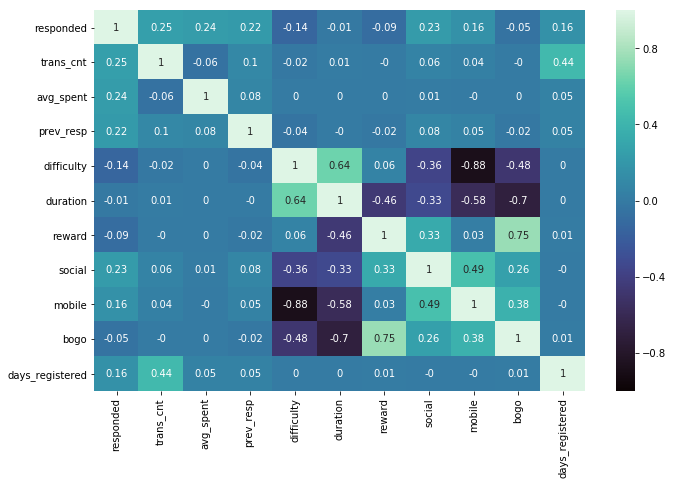

In [59]:
# Check correlations excluding demographic data because we have nulls
plt.figure(figsize = (11,7))
sns.heatmap(np.round(df.drop(['age', 'gender', 'income'], axis = 1).corr(), 2), annot = True, cmap = 'mako', vmin = -1, vmax = 1)

So pairs with high correlation are:
* mobile & difficulty -0.88
* bogo & reward 0.75
* bogo & duration 0.7
* mobile & duration -0.58
* difficulty & duration 0.64

All of them are in Portfolio dataset which had very few rows, so it makes sense.

Columns to drop:
* duration - it has -0.01 correlation with target column
* difficulty - mobile has higher correlation with target column
* bogo - reward has higher correlattion with target column

In [60]:
# Drop columns
df.drop(['duration', 'difficulty', 'bogo'], axis = 1, inplace = True)

In [61]:
# Split
df_nulls = df[df['age'] == 118].drop(['gender', 'income', 'age'], axis = 1)
df = df[df['age'] != 118]

We still need to get dummies for Gender, it wasn't possible up to this point because we had nulls.

In [62]:
# Get Dummies
df = pd.get_dummies(df, drop_first = True)

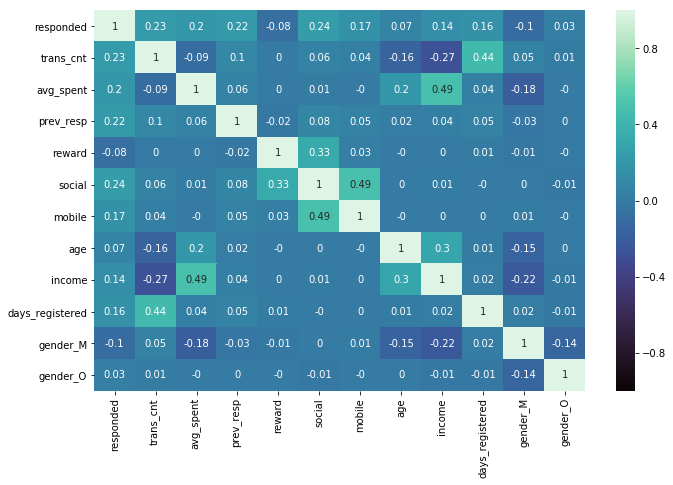

In [63]:
# Check correlations
plt.figure(figsize = (11,7))
sns.heatmap(np.round(df.corr(), 2), annot = True, cmap = 'mako', vmin = -1, vmax = 1)

**Findings**

* Gender_O has low correlation with target column so we can drop it
* mobile and social have moderate correlation, they are part of the same offer sometimes so it makes sense
* it's logical that income and avg_spent are somewhat positively correlated
* days_registered and trans_cnt are moderately positively correlated, which is also logical

For moderately or lowly correlated columns, we'll test whether it's worth leaving them after we start modeling. These columns are:
1. days_registered - 0.44 correlation with trans_cnt, 0.16 with target column opposed to 0.22 of trans_cnt
2. income - 0.49 correlation with avg_spent, 0.14 with target column opposed to 0.2 of avg_spent
3. mobile - 0.49 correlation with social, 0.17 with target column opposed to 0.24 of social
4. reward - -0.08 to target column
5. age - 0.07 to target column

In [64]:
# Drop gender_O
df.drop('gender_O', axis = 1, inplace = True)

In [65]:
# df, df_nulls = af.transform_data(portfolio, profile, transcript)

# Data Modeling

For modeling we train three classifiers with different parameter sets using GridSearchCV: Random Forests, Logistic Regression and KNeighbors. We do it for both df and df_nulls. For df_nulls, we might end up using none of them, depends whether the columns we have are enough to make decent predictions.

As for the metrics to evaluate our models, we'll use accuracy and F1.
We need accuracy because every True Positive is potential income and every False Negative is potential cost avoided.
We need F1 because we need both precision and recall to be decent. With high precision we make sure our investment will lead to high conversion, with high recall, we make sure we don't miss a lot of potential conversions.

#### First we need to scale data and split into training and validation sets

In [66]:
def split_and_scale(df,scale_cols):
    '''
    DESCRIPTION
    Takes dataframe and column names to scale, splits the dataframe into X and y, scales scale_cols for X
    and splits to train and test sets
    
    INPUT
    df - dataframe to split
    scale-cols - columns to scale
    
    OUTPUT
    X_train - featurs for training
    y_train - target column for training
    X_test - features for testing
    y_test - target column for testing
    scaler - column scaler
    
    
    '''
    # Split to X and y
    X = df.drop('responded', axis = 1)
    y = df['responded']
    
    # Scale
    scaler = StandardScaler()
    X[scale_cols] = scaler.fit_transform(X[scale_cols])
    
    # Split to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # Return
    return X_train, X_test, y_train, y_test, scaler

In [67]:
# Create list of column names to scale, they're different for dataframes with and without demohraphic data
scale_cols = ['reward', 'age', 'income', 'days_registered', 'trans_cnt', 'avg_spent']

In [68]:
# First let's try dataset with demographic data
X_train, X_test, y_train, y_test, scaler = split_and_scale(df, scale_cols)

#### Train and evaluate 

In [69]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    '''
    DESCRIPTION
    Takes train and test datasests, trains three models with different parameter sets, prints
    F1 score and accuracy comparison and returns the best model.
    
    INPUT
    X_train - featurs for training
    y_train - target column for training
    X_test - features for testing
    y_test - target column for testing
    
    OUTPUT
    best_model - model with the highest F1 score
    '''
    # Create dictionary to keep scores
    scores = dict()
    
    # Start Time
    start = time.time()
    
    # Print to notify that training has started
    print('Started training...')
    print()
    
    # Create parameter grid for Random Forest Classifier
    param_grid_rfc = { 
    'n_estimators': [20, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,8,10],
    'criterion' :['gini', 'entropy']
    }
    
    # Create, fit and train RFC
    rfc_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rfc)
    rfc_grid.fit(X_train, y_train)
    y_pred_rfc = rfc_grid.predict(X_test)
    
    # Add results to dictionary
    scores['rfc'] = [f1_score(y_test, y_pred_rfc), accuracy_score(y_test,y_pred_rfc)]
    
    # End time
    end = time.time()
    
    # Print notifications
    print('rfc done.')
    print('time : {}'.format(end - start))
    print('Params : {}'.format(rfc_grid.best_params_))
    print()
    
    # Start time
    start = time.time()
    
    # Create grid for Logistic Regression
    param_grid_log_reg = { 
    'C': [2, 5, 10],
    'solver': ['lbfgs', 'liblinear', 'sag']
    }
    
    # Create, fit and train Logistic Regression model
    log_reg_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_log_reg)
    log_reg_grid.fit(X_train, y_train)
    y_pred_log_reg = log_reg_grid.predict(X_test)
    
    # Add results to dictionary
    scores['log_reg'] = [f1_score(y_test, y_pred_log_reg), accuracy_score(y_test,y_pred_log_reg)]
    
    # End time
    end = time.time()
    
    # Print notificatitons
    print('log_reg done.')
    print('time : {}'.format(end - start))
    print('Params : {}'.format(log_reg_grid.best_params_))
    print()
    
    # Start time
    start = time.time()
    
    # Create grid for KNeighborsClasifier
    param_grid_knn = { 
    'n_neighbors': [5, 10],
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': [30, 50]
    }
    
    # Create, fit and train KNeighbors classifier
    knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn)
    knn_grid.fit(X_train, y_train)
    y_pred_knn = knn_grid.predict(X_test)
    
    # Add results to dictionary
    scores['knn'] = [f1_score(y_test, y_pred_knn), accuracy_score(y_test,y_pred_knn)]
    
    # End time
    end = time.time()
    
    # Print notifications
    print('knn done.')
    print('time : {}'.format(end - start))
    print('Params : {}'.format(knn_grid.best_params_))
    print()
    
    # Create dataframe from scores and display
    df = pd.DataFrame.from_dict(scores, orient='index', columns = ['F1', 'Accuracy'])
    display(df)
    
    # Get best model name
    best_model = df.sort_values('F1', ascending = False).index[0]
    
    # Return best model
    if best_model == 'rfc':
        return rfc_grid
    elif best_model == 'log_reg':
        return log_reg_grid
    else:
        return knn_grid

In [70]:
# Train and evaluate models with df
best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)

Started training...

rfc done.
time : 77.52124834060669
Params : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 20}

log_reg done.
time : 26.04988694190979
Params : {'C': 2, 'solver': 'lbfgs'}

knn done.
time : 98.85002779960632
Params : {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 10}



,F1,Accuracy
rfc,0.723363,0.766826
log_reg,0.636542,0.721614
knn,0.665917,0.735705


**Findings**
* Random Forest Classifier has the higheest F1 as well as the highest Accuracy, so no competition there. And both scores are above 0.7 so they're decent.

In [72]:
# Let's check non-demographic one
scale_cols_nulls = ['reward', 'days_registered', 'trans_cnt', 'avg_spent']
X_train_nulls, X_test_nulls, y_train_nulls, y_test_nulls, scale_nulls = split_and_scale(df_nulls, scale_cols_nulls)

In [74]:
# Train and evaluate models with df_nulls
best_model_nulls = train_and_evaluate_models(X_train_nulls, y_train_nulls, X_test_nulls,  y_test_nulls)

Started training...

rfc done.
time : 11.334111213684082
Params : {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 40}

log_reg done.
time : 8.885775089263916
Params : {'C': 10, 'solver': 'sag'}

knn done.
time : 3.9750335216522217
Params : {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 10}



,F1,Accuracy
rfc,0.375940,0.885095
log_reg,0.349869,0.885095
knn,0.348894,0.877711


**Findings**
* Accuracy looks good, but we could get 88% with just putting 0-s for every row
* F1 is really low for all of them, so the model doesn't really help that much

So for users without any demographic data, we can just assume they won't respond to such offers. The company might try to either get more information about these users or try different types of offers.

## Create Classifier
As we see, Random Forest Classifier was the best. The classifier transforms data, fits RFC model and makes predictions whether a user will respond to an offer.

The classifier is fitted on Portfolio, Profile and Transcript datasets. To predict, it should be provided a path to a csv of person & offer_id pairs and a path to output predictions (person, offer_id, responded). If responded is 1 then user is likely to respond, if 0 then is not.

As the test set we use offers received in the last hour (576) of testing. Person & offer_id pairs are in xtest.csv and responded column is in y_test.csv. Also, the classifier contains a single line enabling it for testing and it should be removed if used outside of it.

Below are functions that the Classifier class uses, they are very similar to the ones that are used to functions used up to this point.

In [101]:
def transform_data_to_fit(portfolio, profile, transcript):
    '''
    DESCRIPTION
    Takes portfolio, profiile and transcript, cleanes and merges them
    
    INPUT
    portfilio - dataframe containing campaign data
    profile - dataframe containing user data
    transcript - dataframe containing transaction data
    
    OUTPUT
    df - cleaned and merged dataset with demographic data present
    profile_cleaned - cleaned profile dataframe
    portfolio_cleaned - cleaned portfolio dataframe
    transcript_cleaned - cleaned transcript dataframe
    '''
    # Clean Dataframes
    portfolio_cleaned = clean_portfolio(portfolio)
    profile_cleaned = clean_profile(profile)
    transcript_cleaned = engineer_prev_resp_for_fit(engineer_event_aggs(process_transcript(transcript), transcript))
    
    # Merge Cleaned Dataframes
    df = transcript_cleaned.merge(portfolio_cleaned, how = 'inner', on = 'offer_id')
    df = df.merge(profile_cleaned, how = 'inner', on = 'person')
    
    # Drop person & offer_id & time
    df.drop(['person', 'offer_id', 'time', 'duration', 'difficulty', 'bogo'], axis = 1, inplace = True)
    
    # Remove users with age == 118
    df = df[df['age'] != 118]
    
    # Get dummies for Gender 
    df = pd.get_dummies(df, drop_first = True)
    
    # Drop gender_O for low correlation
    df.drop('gender_O', axis = 1, inplace = True)
    
    # Return
    return df, profile_cleaned, portfolio_cleaned, transcript_cleaned

def get_and_transform_data_to_predict(pairs_path, profile_cleaned, portfolio_cleaned, transcript, transcript_cleaned):
    '''
    DESCRIPTION
    Receives person & offer pairs and creates dataframes for training
    
    INPUT
    portfilio - dataframe containing campaign data
    profile - dataframe containing user data
    transcript - dataframe containing transaction data
    transcript_cleaned - cleaned transactions data
    
    OUTPUT
    df - cleaned and merged dataset with demographic data present
    df_ids - dataframe with id, person and offer_id columns
    df_nulls - cleaned and merged dataset with no demographic data
    '''
    # Clean Dataframes
    pairs = pd.read_csv(pairs_path)
    pairs_new = engineer_event_aggs(pairs, transcript)
    pairs_new = engineer_prev_resp(pairs_new, transcript_cleaned)
    
    # Merge Cleaned Dataframes
    df = pairs_new.merge(portfolio_cleaned, how = 'left', on = 'offer_id')
    df = df.merge(profile_cleaned, how = 'left', on = 'person')
    
    # Split into dataframes, one with demographic data and the other without
    df_nulls = df[df['age'] == 118][['person', 'offer_id']]
    df = df[df['age'] != 118]
    
    # Manually assign 0-s to users with no demographic data
    df_nulls['responded'] = 0
    
    # Drop person & offer_id
    df_ids = df[['person', 'offer_id']]
    df.drop(['person', 'offer_id', 'duration', 'difficulty', 'bogo'], axis = 1, inplace = True)
    
    # Get dummies for Gender 
    df = pd.get_dummies(df, drop_first = True)
    
    # Drop gender_O
    df.drop('gender_O', axis = 1, inplace = True)
    
    # Return
    return df, df_ids, df_nulls


def train_model(X_train, y_train):
    '''
    DESCRIPTION
    Train RandomForestClassifier
    
    INPUT
    X_train - featurs for training
    y_train - target column for training
    
    OUTPUT
    rfc_grid - rfc model with best parameters
    '''
    # Start time
    start = time.time()
    
    # Create parameter grid
    param_grid_rfc = { 
    'n_estimators': [20, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,8,10],
    'criterion' :['gini', 'entropy']
    }
    
    # Create and train classifier
    rfc_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rfc)
    rfc_grid.fit(X_train, y_train)
    
    # End time
    end = time.time()
    
    # Print notifications
    print('Model is ready')
    print('Training time : {}'.format(end - start))
    print('Params : {}'.format(rfc_grid.best_params_))
    print()
    
    # Return model
    return rfc_grid

def engineer_prev_resp(pairs, transcript_cleaned):
    '''
    DESCRIPTION
    For each person-offer pair returns whether the person previously responded to the same offer as column 'prev_resp'
    prev_resp - 1 if a user previously responded, 0 if didn't
    
    INPUT
    transcript_new - prediction transcript
    transcript_cleand - training transcript, which contains responses for each person-offer pair
    
    OUTPUT
    transcript_new - prediction transcript with 'prev_resp' column added
    '''
    # For each person-offer pair return responded
    transcript_cleaned = transcript_cleaned[transcript_cleaned['responded'] == 1][['person', 'offer_id', 'responded']].drop_duplicates()
    
    # Add responded column
    pairs = pairs.merge(transcript_cleaned, how = 'left', on = ['person', 'offer_id'])
    pairs.rename({'responded' : 'prev_resp'}, axis = 1, inplace = True)
    pairs['prev_resp'].fillna(0, inplace = True)
    
    # Return
    return pairs

In [102]:
class Classifier():
    '''
    A classifier that uses portfolio, profile and transcript to train RandomForestClassifier and predict whether a user
    will respond to an offer for person & offer_id pairs.
    '''
    
    def __init__(self):
        '''
        DESCRIPTION
        Nothing to see here
        '''
        
    def fit(self, portfolio_path, profile_path, transcript_path):
        '''
        DESCRIPTION
        Reads portfolio, profile and transcript databases, transforms and merges them and trains RandomForestTClassifier
        
        INPUT
        portfolio_path - path to portfolio dataset
        profile_path - path to profile dataset
        transcript_path - path to transcript dataset
        
        OUTPUT
        self.df - cleaned and merged dataset
        self.profile_cleaned - cleaned profile dataset
        self.portfolio_cleaned - cleaned portfolio dataset
        self.transcript_cleaned - cleaned transcript dataset
        self.transcript - transcript dataset
        self.scalee_cols - columns to scale
        self.model - trained rfc modeel
        '''
        # Notification
        print('Importing Data')
        
        # Import and clean datasets
        portfolio = pd.read_json(portfolio_path, orient='records', lines=True)
        profile = pd.read_json(profile_path, orient='records', lines=True)
        transcript = pd.read_json(transcript_path, orient='records', lines=True)
        
        # Uncomment if testing in jupyter notebooks
        transcript = transcript[(transcript['time'] != 576) | (transcript['event'] != 'offer received')]
        
        # Notification
        print('Transforming Data')
        
        # Prepare datasets for training
        self.df, self.profile_cleaned, self.portfolio_cleaned, self.transcript_cleaned = transform_data_to_fit(portfolio, profile, transcript)
        
        # Save transcript
        self.transcript = transcript
        
        # Create scale_cols
        self.scale_cols = ['reward', 'age', 'income', 'days_registered', 'trans_cnt', 'avg_spent']
        
        # Notification
        print('Training RFC Model')
        
        # Split datasets into train and test, scale train data
        X_train, X_test, y_train, y_test, self.scaler = split_and_scale(self.df, self.scale_cols)
        
        # Train model
        self.model = train_model(X_train, y_train)
        
    def predict(self, pairs_path, result_path):
        '''
        DESCRIPTION
        Takes person & offer_id pairs and predicts whether a user responds, 1 if responds, 0 if won't
        
        INPUT
        pairs_path - csv with person & offer_id pairs
        
        OUTPUT
        a csv with person & offer_id & response columns
        '''
        # Get and transfrom data
        df_pred, df_ids, df_pred_nulls = get_and_transform_data_to_predict(pairs_path, self.profile_cleaned, self.portfolio_cleaned, self.transcript, self.transcript_cleaned)
        
        # Scale columns
        df_pred[self.scale_cols] = self.scaler.transform(df_pred[self.scale_cols])
        
        # Predict
        y_pred = self.model.predict(df_pred)
        df_ids['responded'] = y_pred
        
        # Create final dataframe
        predictions = pd.concat([df_ids, df_pred_nulls])
        
        # Export to csv
        predictions.to_csv(result_path)

In [103]:
# Create instance
clf = Classifier()

# Fit Classifier
clf.fit('data/portfolio.json', 'data/profile.json', 'data/transcript.json')

# Predict
clf.predict('data/xtest.csv', 'data/preds.csv')

# Result Evaluation

In [106]:
y_pred = pd.read_csv('data/preds.csv')
y_test = pd.read_csv('data/ytest.csv')

In [107]:
# Set index to compare with y_test
y_pred = y_pred.set_index('Unnamed: 0').sort_index()

In [108]:
# Print scores
print('F1 score : {}'.format(f1_score(y_test['responded'], y_pred['responded'])))
print()
print('Accuracy score: {}:'.format(accuracy_score(y_test['responded'], y_pred['responded'])))
print()
print('Confusion matrix:')
print(confusion_matrix(y_test['responded'], y_pred['responded']))

F1 score : 0.6728262245285407

Accuracy score: 0.745945945945946:

Confusion matrix:
[[4932 1582]
 [1003 2658]]


0.67 F1 score and 0.75 accuracy is decent but it's not great.

# Final thoughts

There probably are a number of additional steps we can take to make our scores better:
1. a deeper dive into EDA would be helpful to catch relationships
2. come up and engineer new features
3. handle nulls better, currently we simply put 0s for users without demographic data
4. maybe divide train and testing sets better
5. better error handling, runs without errors currently but it's not ready for production

Main challenges:
1. again, handling nulls and default values
2. feature engineering

Interesting parts:
1. super interesting to go through the whole end-to-end process
2. business problem is very realistic